
# Lesson L1 (Week 2) – Visualising Naive Bayes Likelihoods 📈🔵🔴

Welcome to **Week 2, Lesson L1** of the *Practical NLP for Beginners* mini‑course!

### 👩🏻‍🏫 What you’ll learn in the next 30 minutes
* **Recap the Naive Bayes classifier** and why log‑likelihoods are handy.
* **Generate features on‑the‑fly** — no external CSV needed.
* **Plot tweets in likelihood space** and see the decision boundary appear.
* **Interpret confidence ellipses** around positive vs. negative sentiment.
* **Play with an interactive explorer** and watch probabilities update live.

> **Prerequisites:** only basic Python and NumPy.  
> **Goal:** gain an *intuitive* feel for how Naive Bayes classifies text.



---  
### 🆕 What’s different from the original Coursera lab?
| Change | Why it matters |
|--------|----------------|
| **Features generated in‑notebook** | Everything is reproducible — no `bayes_features.csv` download. |
| **Coursera‑compatible names** | You can still follow Andrew’s videos line‑by‑line. |
| **Tiny toy walk‑through** | The maths becomes tangible before we scale up. |
| **Interactive Gradio explorer** | Probe single tweets and *see* the numbers change. |


## 🍀 0 – Environment set‑up (≈ 1 min)

In [1]:
# 🍀 Setup – installs take ~45 s ⏳
!pip -q install --upgrade nltk wordcloud gradio>=4.27.0 numpy>=1.26,<2.1 scikit-learn<1.7 websockets>=13,<15 --progress-bar off

import nltk, ssl, warnings; warnings.filterwarnings('ignore')
try:
    ssl._create_default_https_context = ssl._create_unverified_context
except AttributeError:
    pass
for res in ['stopwords', 'punkt', 'twitter_samples']:
    nltk.download(res, quiet=True)
print('✅ Environment ready')

/bin/bash: line 1: 2.1: No such file or directory
✅ Environment ready



That single cell:

1. Installs the **only external libraries** we need.  
2. Downloads three corpora from *NLTK*.  
3. Prints a green check ✔️ when done.

> **Tip:** if the download fails once, just rerun — it is cached after the first success.


## 1️⃣ Toy example – six tiny tweets


We warm up with *six* two‑word tweets:

```text
Positive →  love it | so happy | great day
Negative →  hate it | so sad   | bad day
```

A microscopic dataset means we can **calculate every probability by hand** and *see* how Laplace smoothing nudges them.


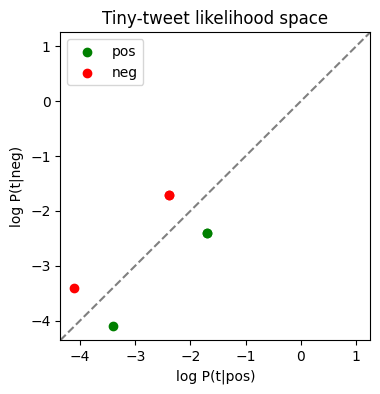

In [2]:
import numpy as np, re, matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stemmer, stop_words = PorterStemmer(), set(stopwords.words('english'))

def clean(t: str):
    """Lower‑case → remove non‑letters → tokenize → stop‑word filter → stem"""
    t = t.lower()
    t = re.sub(r'[^a-z\s]', '', t)
    return [stemmer.stem(w) for w in t.split() if w not in stop_words]

# Tiny corpus
t_pos = ["love it", "so happy", "great day"]
t_neg = ["hate it", "so sad", "bad day"]
tweets = t_pos + t_neg
ys = np.array([1]*3 + [0]*3)  # 1 = pos, 0 = neg

# Likelihood helpers --------------------------------------------------------
from collections import Counter
def word_likelihoods(pos, neg, alpha=1):
    pos_counts = Counter(w for tw in pos for w in clean(tw))
    neg_counts = Counter(w for tw in neg for w in clean(tw))
    vocab = set(pos_counts)|set(neg_counts); V = len(vocab)
    tot_pos = sum(pos_counts.values()) + alpha*V
    tot_neg = sum(neg_counts.values()) + alpha*V
    lp = {w: np.log((pos_counts[w]+alpha)/tot_pos) for w in vocab}
    ln = {w: np.log((neg_counts[w]+alpha)/tot_neg) for w in vocab}
    return lp, ln

lp, ln = word_likelihoods(t_pos, t_neg)

def tweet_ll(t):
    toks = clean(t)
    lpos = sum(lp.get(w, 0) for w in toks)
    lneg = sum(ln.get(w, 0) for w in toks)
    return lpos, lneg

XY = np.array([tweet_ll(t) for t in tweets])
plt.figure(figsize=(4,4))
plt.scatter(XY[:3,0], XY[:3,1], c='green', label='pos')
plt.scatter(XY[3:,0], XY[3:,1], c='red', label='neg')
plt.axline((0,0), (1,1), ls='--', c='grey')
plt.xlabel('log P(t|pos)'); plt.ylabel('log P(t|neg)')
plt.title('Tiny‑tweet likelihood space'); plt.legend(); plt.show()


🎨 **Reading the picture**

* Each dot is a **tweet** embedded in 2‑D: \((\log P(t\mid\text{pos}),\log P(t\mid\text{neg}))\).
* The **grey dashed line** is where the two logs are equal — our *decision boundary* when priors are 50 / 50.
* Points below the line have larger positive likelihood → classified *positive*, and vice‑versa.

> **Play:** change `alpha` in `word_likelihoods` or modify a tweet, rerun, and watch the dots move!


## 2️⃣ Helper functions for the full corpus


The next cell builds two helpers:

1. **`process_tweet`** – lower‑cases, strips URLs, removes punctuation & stop‑words, then stems.  
2. **`build_likelihoods`** – computes smoothed log‑likelihood dictionaries for *all* words.

Feel free to tweak the pre‑processing or smoothing factor *α*.


In [3]:
import re, numpy as np
from nltk.corpus import twitter_samples
from collections import Counter
stemmer, stop_words = PorterStemmer(), set(stopwords.words('english'))

def process_tweet(t: str):
    t = t.lower()
    t = re.sub(r'https?://\S+', '', t)
    t = re.sub(r'[^a-z\s]', '', t)
    return [stemmer.stem(w) for w in t.split() if w not in stop_words]

def build_likelihoods(tweets, ys, alpha=1):
    pos = [tw for tw, y in zip(tweets, ys) if y == 1]
    neg = [tw for tw, y in zip(tweets, ys) if y == 0]
    pos_c = Counter(w for tw in pos for w in process_tweet(tw))
    neg_c = Counter(w for tw in neg for w in process_tweet(tw))
    vocab = set(pos_c)|set(neg_c); V = len(vocab)
    tot_p = sum(pos_c.values()) + alpha*V
    tot_n = sum(neg_c.values()) + alpha*V
    lp = {w: np.log((pos_c[w]+alpha)/tot_p) for w in vocab}
    ln = {w: np.log((neg_c[w]+alpha)/tot_n) for w in vocab}
    return lp, ln

## 3️⃣ Real‑corpus likelihood scatter & confidence ellipses


The NLTK Twitter corpus has 5 000 positive and 5 000 negative tweets labelled by crowd‑workers.

We’ll plot a **random sample of 2 000** and draw **95 % confidence ellipses** so the class shapes are still visible.


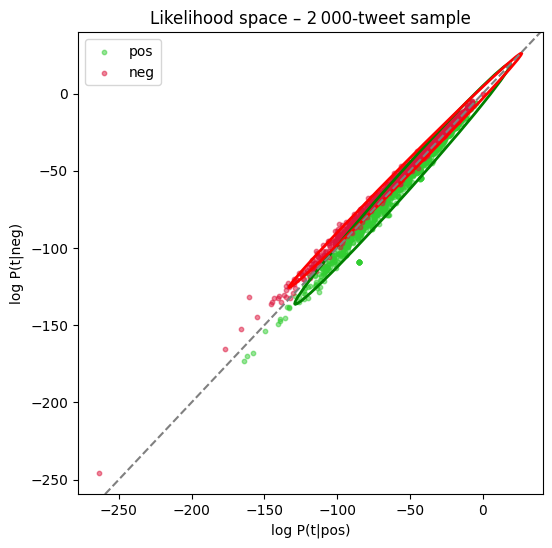

In [8]:
tweets_pos = twitter_samples.strings('positive_tweets.json')
tweets_neg = twitter_samples.strings('negative_tweets.json')
tweets = tweets_pos + tweets_neg
ys = np.array([1]*len(tweets_pos) + [0]*len(tweets_neg))

lp, ln = build_likelihoods(tweets, ys)

def tweet_ll_real(t):
    toks = process_tweet(t)
    return sum(lp.get(w,0) for w in toks), sum(ln.get(w,0) for w in toks)

XY_full = np.array([tweet_ll_real(t) for t in tweets])
np.random.seed(0)
idx = np.random.choice(len(tweets), 2000, replace=False)
XY = XY_full[idx]; y_s = ys[idx]

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(XY[y_s==1,0], XY[y_s==1,1], s=10, c='limegreen', label='pos', alpha=0.5)
ax.scatter(XY[y_s==0,0], XY[y_s==0,1], s=10, c='crimson', label='neg', alpha=0.5)
ax.axline((0,0), (1,1), ls='--', c='grey')

def ellipse(data, color):
    import numpy.linalg as LA
    cov = np.cov(data, rowvar=False)
    mean = data.mean(axis=0)
    vals, vecs = LA.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * np.sqrt(vals * 5.991)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=theta,
                  edgecolor=color, facecolor='none', lw=2)
    ax.add_patch(ell)


ellipse(XY[y_s==1], 'green'); ellipse(XY[y_s==0], 'red')
ax.set_xlabel('log P(t|pos)'); ax.set_ylabel('log P(t|neg)')
ax.set_title('Likelihood space – 2 000‑tweet sample'); ax.legend(); plt.show()


🔍 **Interpreting the ellipses**

* They enclose approximately 95 % of tweets *if* the class distributions were Gaussian.  
* **Tilt** → correlation between the two log‑likelihoods.  
* **Area** → overall variance (here, negative tweets are slightly more spread).

> **Exercise:** bump the sample size from 2 000 to 10 000 (all tweets). Does the plot look more or less Gaussian?


## 4️⃣ Interactive likelihood explorer


Type *any* sentence below and watch the numbers appear.

| Field | Meaning |
|-------|---------|
| **log P(t\|pos)** | Sum of per‑word logs under the positive model |
| **log P(t\|neg)** | Same, but negative |
| **Posterior P(pos)** | Assuming equal class priors |
| **Prediction** | Emoji‑level TL;DR |

Try:

* “I absolutely adore this!” → should go green.  
* “This is the worst thing ever.” → likely red.  
* “Nothing special, meh.” → often near 0.5, showing model uncertainty.


In [7]:
import gradio as gr

def explorer(txt):
    lpv, lnv = tweet_ll_real(txt)
    prob = 1 / (1 + np.exp(lnv - lpv))
    return {
        "log P(t|pos)": round(lpv, 3),
        "log P(t|neg)": round(lnv, 3),
        "Posterior P(pos)": round(prob, 3),
        "Prediction": "Positive 😊" if prob >= 0.5 else "Negative 😞"
    }

with gr.Blocks() as demo:
    gr.Markdown('### 🕵️ Likelihood explorer (Naive Bayes)')
    inp = gr.Textbox(lines=3, label='Tweet text')
    out = gr.JSON()
    inp.submit(explorer, inp, out)
    gr.Button('Run').click(explorer, inp, out)

# Uncomment when running locally or on Colab:
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://131564443a638b4b65.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



---

🎉 **Congratulations!** You visualised Naive Bayes likelihoods, interpreted class uncertainty, and built an interactive demo—*all in one notebook*.

### ✏️ Mini‑project
1. Replace the Twitter corpus with **your own data** (e.g. IMDB reviews).  
2. Re‑train `build_likelihoods`.  
3. Plot the new space — does the separation get cleaner or messier?  
4. Share a screenshot with the community!
